# Tarea Semanal 8: Filtrado de señales
## Magdalena Noé
Diseñe y aplique los filtros digitales necesarios para mitigar las siguientes fuentes de contaminación:
- Ruido causado por el movimiento de los electrodos (Alta frecuencia).
- Ruido muscular (Alta frecuencia).
- Movimiento de la línea de base del ECG, inducido en parte por la respiración (Baja frecuencia).

*a) Establezca una plantilla de diseño para los filtros digitales que necesitará para que la señal de ECG se asemeje a los latidos promedio en cuanto a  suavidad de los trazos y nivel isoeléctrico nulo.*

Ayuda:  Utilice los resultados del ancho de banda estimado del ECG en la Tarea Semanal anterior. Tome como referencia las siguientes morfologías promedio para evaluar cualitativamente la efectividad de los filtros diseñados.
¿Qué significa "complejo QRS"?
Se llama "complejo" porque está compuesto por tres ondas:

- Q: una pequeña deflexión negativa (hacia abajo).
- R: una gran deflexión positiva (pico hacia arriba).
- S: otra deflexión negativa posterior al pico.

Juntas forman una especie de “pico agudo” que es fácil de detectar visualmente.

*b) ¿Cómo obtuvo dichos valores? Describa el procedimiento para establecer los valores de la plantilla.*



```Archivo ECG.mat```
- ecg_lead: Registro de ECG muestreado a $f_s=1$  KHz durante una prueba de esfuerzo
- qrs_pattern1: Complejo de ondas QRS normal
- heartbeat_pattern1: Latido normal
- heartbeat_pattern2: Latido de origen ventricular
- qrs_detections: vector con las localizaciones (en # de muestras) donde ocurren los latidos

### Librerias

In [1]:
import matplotlib.pyplot as plt
from numpy.fft import fft #Para poder escribir fft() en vez de numpy.fft.fft()
import numpy as np
from scipy import signal as sig
import scipy.io as sio

### Cargo señal ECG

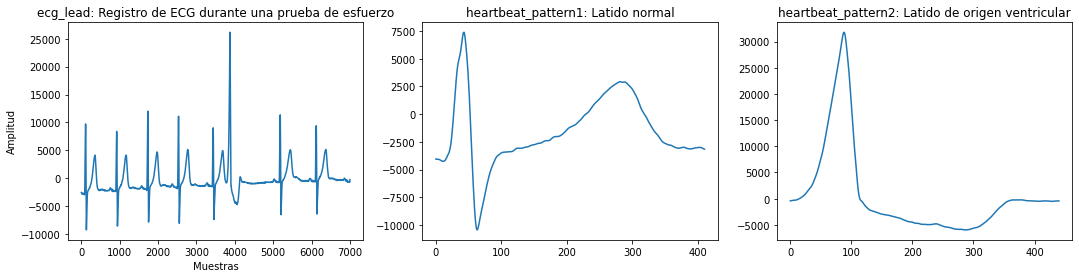

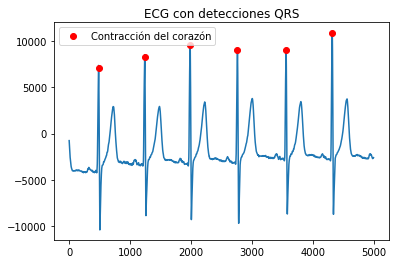

In [34]:
fs = 1000 # Hz

# para listar las variables que hay en el archivo
sio.whosmat('signals_ts8/ecg_signal.mat')
mat_struct = sio.loadmat('signals_ts8/ecg_signal.mat')

ecg_one_lead = mat_struct['ecg_lead']
N = len(ecg_one_lead)

hb_1 = mat_struct['heartbeat_pattern1'] #Latido normal
### Usarlo para:
#Analizar la morfología de un latido típico.
#Comparar con latidos patológicos.
hb_2 = mat_struct['heartbeat_pattern2'] # Latido ventricular (anormal) Latido patológico, como una extrasístole ventricular.
### Usarlo para:
#Comparación con heartbeat_pattern1 para distinguir latidos normales y anormales.
#Entrenamiento de clasificadores o algoritmos de detección
qrs_pat = mat_struct['qrs_pattern1'] 
### Usarlo para: 
#plantilla para detección de latidos (cross-correlation, matched filter).
#Para comparar latidos normales y anormales.
qrs_detect = mat_struct['qrs_detections'] # Vector con las posiciones (índices de muestra) donde se detectaron complejos QRS en ecg_lead
### Usarlo para:
#Marcar los latidos en la señal ecg_lead.
#Extraer cada latido para análisis automático.
#Calcular intervalos RR (tiempo entre latidos) → frecuencia cardíaca.

plt.figure(figsize=(18, 4))
plt.subplot(1,3,1); plt.title("ecg_lead: Registro de ECG durante una prueba de esfuerzo")
plt.xlabel("Muestras"); plt.ylabel("Amplitud")
plt.plot(ecg_one_lead[5000:12000]) # 6 segundos

plt.subplot(1,3,2); plt.title("heartbeat_pattern1: Latido normal")
plt.plot(hb_1)

plt.subplot(1,3,3); plt.title("heartbeat_pattern2: Latido de origen ventricular")
plt.plot(hb_2)

plt.figure()
plt.plot(ecg_one_lead[0:5000])
plt.plot(qrs_detect[qrs_detect < 5000], ecg_one_lead[qrs_detect[qrs_detect < 5000]], 'ro', label='Contracción del corazón')
plt.title("ECG con detecciones QRS")
plt.legend()
'''Los complejos QRS son una de las partes más importantes de la señal de ECG (electrocardiograma), 
y representan la despolarización de los ventrículos, es decir, el momento en que el corazón se contrae para bombear sangre.'''
plt.show()

In [35]:
'''
nyq_frec = fs/2
ripple = 1 # dB
atenuacion = 40 # dB
 
ws1 = ?? # Hz
wp1 = ?? # Hz
wp2 = ?? # Hz
ws2 = ?? # Hz
 
# plantilla normalizada a Nyquist en dB
frecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
 
# convertimos a veces para las funciones de diseño
gains = 10**(gains/20)
'''

'\nnyq_frec = fs/2\nripple = 1 # dB\natenuacion = 40 # dB\n \nws1 = ?? # Hz\nwp1 = ?? # Hz\nwp2 = ?? # Hz\nws2 = ?? # Hz\n \n# plantilla normalizada a Nyquist en dB\nfrecs = np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec\ngains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])\n \n# convertimos a veces para las funciones de diseño\ngains = 10**(gains/20)\n'

## Diseño y comparacion de filtros FIR y IIR

*c) Diseñe al menos dos filtros FIR y dos IIR para su comparación. Verifique que la respuesta en frecuencia responda a la plantilla de diseño.*

Ayuda: Para los filtros IIR adopte las aproximaciones de módulo de máxima planicidad, Chebyshev y Cauer. Para los FIR, utilice las metodologías de ventanas, cuadrados mínimos y Parks-Mc Clellan-Remez. Todos implementados en SciPy.Signal

*d)  Evalúe el rendimiento de los filtros que haya diseñado:*

Verifique que filtra las señales interferentes.
Verifique que es inocuo en las zonas donde no hay interferentes.
Ayuda: Utilice el siguiente código como referencia para analizar los puntos 1 y 2). También puede incluir otras regiones que considere de interés.

In [36]:
'''
regs_interes = (
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure(1)
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
   
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()
 
###################################
#%% Regiones de interés sin ruido #
###################################
 
regs_interes = (
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )
 
for ii in regs_interes:
   
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
   
    plt.figure(2)
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')
   
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
   
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
           
    plt.show()

'''

"\nregs_interes = (\n        [4000, 5500], # muestras\n        [10e3, 11e3], # muestras\n        )\n \nfor ii in regs_interes:\n   \n    # intervalo limitado de 0 a cant_muestras\n    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')\n   \n    plt.figure(1)\n    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)\n    #plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butterworth')\n    #plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='FIR Window')\n   \n    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )\n    plt.ylabel('Adimensional')\n    plt.xlabel('Muestras (#)')\n   \n    axes_hdl = plt.gca()\n    axes_hdl.legend()\n    axes_hdl.set_yticks(())\n           \n    plt.show()\n \n###################################\n#%% Regiones de interés sin ruido #\n###################################\n \nregs_interes = (\n        np.array([5, 5.2]) *60*fs, # minutos a muestras\n        np.

Bonus:
💎 Proponga algún tipo de señal, ya sea de la TS anterior u otra que no haya sido analizada y repita el análisis. No olvide explicar su origen y cómo fue digitalizada.